In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Restart runtime after running once

# Library for pretrained segmentation models fo PyTorch
!pip install segmentation-models-pytorch==0.1.0

# Catalyst library
!pip install -U catalyst

     |████████████████████████████████| 51kB 3.2MB/s 
     |████████████████████████████████| 61kB 5.3MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=9b9bea3091bcc2d1cf6601c6cb12e1629a6dedf728a8517676ddbc1e7056ff67
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=aba034bdd075e9a2588f4f34febad68a55ef375b2de90a500b6d20ad979de68e
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built pretrainedmodels efficientnet-pytorch
     |████████████████████████████████| 327kB 6.4MB/s 
     |████████████████████████████████| 204kB 17.4MB/s 
     |████████████████████████████████| 460kB 16.9MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 


In [3]:
# Dependencies

# Handles data 
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from operator import itemgetter

# Torch utilities 
from typing import List
from pathlib import Path
from torch.utils.data import Dataset
import torch

# Data Loader utilities 
import collections
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

# Model building and training 
import segmentation_models_pytorch as smp
from torch import nn

from catalyst.contrib.nn import DiceLoss, IoULoss
from torch import optim
from catalyst import utils

from catalyst.contrib.nn import RAdam, Lookahead
from catalyst.dl import SupervisedRunner

from catalyst.dl.callbacks import DiceCallback, IouCallback, \
  CriterionCallback, AccuracyCallback, MulticlassDiceMetricCallback

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



In [4]:
# Sets a seed for better reproducibility 
SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__



In [0]:
# Defines and establishes a dataset class
class SegmentationDataset(Dataset): 
    def __init__(
        self,
        image_arr_path,
        mask_arr_path,
    ) -> None:
        self.images = np.load(image_arr_path)
        self.masks = np.load(mask_arr_path)

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        image = self.images[idx]
        image = np.swapaxes(image, 2, 0)
        image = np.swapaxes(image, 2, 1)
        image = torch.from_numpy(image).float()
        result = {"image": image}
        
        if self.masks is not None:
            mask = self.masks[idx]
            mask = np.swapaxes(mask, 2, 0)
            mask = np.swapaxes(mask, 2, 1)
            mask = torch.from_numpy(mask).float()
            result["mask"] = mask
        return result

In [0]:
# Loading once to enable visualizion prior to model training 
dset = SegmentationDataset(image_arr_path="/content/drive/Shared drives/Intelligent Ground Vehicle Competition/Previous Year Resources/2019-2020 Season/Software/Collab Notebooks/train_images.npy", 
                           mask_arr_path="/content/drive/Shared drives/Intelligent Ground Vehicle Competition/Previous Year Resources/2019-2020 Season/Software/Collab Notebooks/train_masks.npy")

In [9]:
# Show sizes of the image and mask 
out = dset[0]
out["image"].shape, out["mask"].shape, len(dset)

(torch.Size([3, 480, 640]), torch.Size([1, 480, 640]), 592)

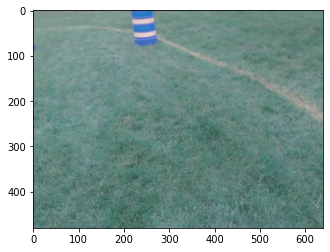

In [10]:
# Show an image 
show_image = np.asarray(dset[40]['image'])
show_image = np.swapaxes(show_image, 2, 0)
show_image = np.swapaxes(show_image, 1, 0)
show_image = show_image.astype(np.uint8)
np.shape(show_image)
plt.imshow(show_image)

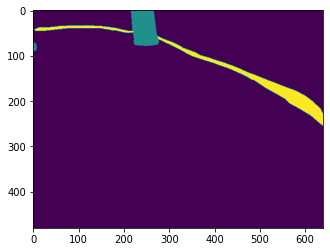

In [11]:
# Show associated mask 

show_mask = np.squeeze(dset[40]['mask'])
plt.imshow(show_mask)

In [15]:
# Set up transfer learning system 
	
ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

# ACTIVATION = 'softmax'
ACTIVATION = None

model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=3, 
    activation=ACTIVATION,
)

# preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/checkpoints/efficientnet-b3-5fb5a3c3.pth


In [0]:
# Define loaders 

def get_loaders(
    images: List[Path],
    masks: List[Path],
    image_arr_path: str,
    mask_arr_path: str,
    random_state: int,
    valid_size: float = 0.1,
    batch_size: int = 12,
    num_workers: int = 4,
    # train_transforms_fn = None,
    # valid_transforms_fn = None,
    ) -> dict:

    indices = np.arange(len(images))

    train_indices, valid_indices = train_test_split(
      indices, test_size=valid_size, random_state=random_state, shuffle=True
    )

    np_images = np.array(images)
    np_masks = np.array(masks)

    #print(np_images.shape, np_masks.shape)
    #print(train_indices)

    train_dataset = SegmentationDataset(image_arr_path, mask_arr_path)
    train_dataset.images = np_images[train_indices]
    train_dataset.masks = np_masks[train_indices]
    #print(len(train_dataset))
    #print(train_dataset.images.shape)
    #print(train_dataset.masks.shape)

    valid_dataset = SegmentationDataset(image_arr_path, mask_arr_path)
    valid_dataset.images = np_images[valid_indices]
    valid_dataset.masks = np_masks[valid_indices]
    #print(len(valid_dataset))
    #print(valid_dataset.images.shape)
    #print(valid_dataset.masks.shape)


    train_loader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=False,
    )

    valid_loader = DataLoader(
      valid_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      drop_last=False,
    )

    loaders = collections.OrderedDict()
    loaders["train"] = train_loader
    loaders["valid"] = valid_loader

    return loaders

In [0]:
# Get loaders  
loaders = get_loaders(
    images=np.load("/content/drive/Shared drives/Intelligent Ground Vehicle Competition/Previous Year Resources/2019-2020 Season/Software/Collab Notebooks/train_images.npy"),
    masks=np.load("/content/drive/Shared drives/Intelligent Ground Vehicle Competition/Previous Year Resources/2019-2020 Season/Software/Collab Notebooks/train_masks.npy"),
    image_arr_path="/content/drive/Shared drives/Intelligent Ground Vehicle Competition/Previous Year Resources/2019-2020 Season/Software/Collab Notebooks/train_images.npy",
    mask_arr_path="/content/drive/Shared drives/Intelligent Ground Vehicle Competition/Previous Year Resources/2019-2020 Season/Software/Collab Notebooks/train_masks.npy",
    random_state=420,
    valid_size=0.1,
    batch_size=3,
    num_workers=2,
)

In [0]:
# Helpful code taken from Joseph Chen 
#
#    Copyright 2019 Division of Medical Image Computing, German Cancer Research Center (DKFZ), Heidelberg, Germany
#
#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at
#
#        http://www.apache.org/licenses/LICENSE-2.0
#
#    Unless required by applicable law or agreed to in writing, software
#    distributed under the License is distributed on an "AS IS" BASIS,
#    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#    See the License for the specific language governing permissions and
#    limitations under the License.

import torch
from torch import nn
import numpy as np

def sum_tensor(inp, axes, keepdim=False):
    axes = np.unique(axes).astype(int)
    if keepdim:
        for ax in axes:
            inp = inp.sum(int(ax), keepdim=True)
    else:
        for ax in sorted(axes, reverse=True):
            inp = inp.sum(int(ax))
    return inp

def softmax_helper(x):
    rpt = [1 for _ in range(len(x.size()))]
    rpt[1] = x.size(1)
    x_max = x.max(1, keepdim=True)[0].repeat(*rpt)
    e_x = torch.exp(x - x_max)
    return e_x / e_x.sum(1, keepdim=True).repeat(*rpt)

class CrossentropyND(nn.CrossEntropyLoss):
    """
    Network has to have NO NONLINEARITY!
    """
    def forward(self, inp, target):
        target = target.long()
        num_classes = inp.size()[1]

        i0 = 1
        i1 = 2

        while i1 < len(inp.shape): # this is ugly but torch only allows to transpose two axes at once
            inp = inp.transpose(i0, i1)
            i0 += 1
            i1 += 1

        inp = inp.contiguous()
        inp = inp.view(-1, num_classes)

        target = target.view(-1,)

        return super(CrossentropyND, self).forward(inp, target)

def get_tp_fp_fn(net_output, gt, axes=None, mask=None, square=False):
    """
    net_output must be (b, c, x, y(, z)))
    gt must be a label map (shape (b, 1, x, y(, z)) OR shape (b, x, y(, z))) or one hot encoding (b, c, x, y(, z))
    if mask is provided it must have shape (b, 1, x, y(, z)))
    :param net_output:
    :param gt:
    :param axes:
    :param mask: mask must be 1 for valid pixels and 0 for invalid pixels
    :param square: if True then fp, tp and fn will be squared before summation
    :return:
    """
    if axes is None:
        axes = tuple(range(2, len(net_output.size())))

    shp_x = net_output.shape
    shp_y = gt.shape

    with torch.no_grad():
        if len(shp_x) != len(shp_y):
            gt = gt.view((shp_y[0], 1, *shp_y[1:]))

        if all([i == j for i, j in zip(net_output.shape, gt.shape)]):
            # if this is the case then gt is probably already a one hot encoding
            y_onehot = gt
        else:
            gt = gt.long()
            y_onehot = torch.zeros(shp_x)
            if net_output.device.type == "cuda":
                y_onehot = y_onehot.cuda(net_output.device.index)
            y_onehot.scatter_(1, gt, 1)

    tp = net_output * y_onehot
    fp = net_output * (1 - y_onehot)
    fn = (1 - net_output) * y_onehot

    if mask is not None:
        tp = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(tp, dim=1)), dim=1)
        fp = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(fp, dim=1)), dim=1)
        fn = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(fn, dim=1)), dim=1)

    if square:
        tp = tp ** 2
        fp = fp ** 2
        fn = fn ** 2

    tp = sum_tensor(tp, axes, keepdim=False)
    fp = sum_tensor(fp, axes, keepdim=False)
    fn = sum_tensor(fn, axes, keepdim=False)

    return tp, fp, fn


class SoftDiceLoss(nn.Module):
    def __init__(self, apply_nonlin=None, batch_dice=False, do_bg=True,
                 smooth=1., square=False):
        super(SoftDiceLoss, self).__init__()

        self.square = square
        self.do_bg = do_bg
        self.batch_dice = batch_dice
        self.apply_nonlin = apply_nonlin
        self.smooth = smooth

    def forward(self, x, y, loss_mask=None):
        shp_x = x.shape

        if self.batch_dice:
            axes = [0] + list(range(2, len(shp_x)))
        else:
            axes = list(range(2, len(shp_x)))

        if self.apply_nonlin is not None:
            x = self.apply_nonlin(x)

        tp, fp, fn = get_tp_fp_fn(x, y, axes, loss_mask, self.square)

        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)

        if not self.do_bg:
            if self.batch_dice:
                dc = dc[1:]
            else:
                dc = dc[:, 1:]
        dc = dc.mean()

        return -dc


class DC_and_CE_loss(nn.Module):
    def __init__(self, soft_dice_kwargs, ce_kwargs, aggregate="sum"):
        super(DC_and_CE_loss, self).__init__()
        self.aggregate = aggregate
        self.ce = CrossentropyND(**ce_kwargs)
        self.dc = SoftDiceLoss(apply_nonlin=softmax_helper, **soft_dice_kwargs)

    def forward(self, net_output, target):
        dc_loss = self.dc(net_output, target)
        ce_loss = self.ce(net_output, target)
        if self.aggregate == "sum":
            result = ce_loss + dc_loss
        else:
            raise NotImplementedError("did not work") 
        return result

In [0]:
# Define loss criterion
criterion = {
    "CE": CrossentropyND(),
}

from torch.optim import AdamW

# Set up optimization 

learning_rate = 0.001 #0.001
encoder_learning_rate = 0.0005
encoder_weight_decay = 0.00003 #0.00003
optimizer_weight_decay = 0.0003 #0.0003
optim_factor = 0.25 #0.25 
optim_patience = 2 #2

optimizer = AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=optim_factor, patience=optim_patience)

num_epochs = 10
device = utils.get_device()

runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

In [0]:
callbacks = [
        CriterionCallback(
            input_key="mask",
            prefix="loss",
            criterion_key="CE"
        ),
        MulticlassDiceMetricCallback(input_key="mask")
        ]

In [22]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    callbacks=callbacks,
    logdir='content/full_model2', #this logdir must be changed with every new run
    num_epochs=num_epochs,
    main_metric="loss",
    minimize_metric=True,
    fp16=None,
    
    
    verbose=True,
)

1/10 * Epoch (train):   0% 0/178 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/efficientnet_pytorch/utils.py:45: DeprecationWarning:

'saved_variables' is deprecated; use 'saved_tensors'



1/10 * Epoch (train):   1% 1/178 [00:05<15:10,  5.15s/it, loss=1.809]

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning:

This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha)



1/10 * Epoch (train): 100% 178/178 [01:23<00:00,  2.12it/s, loss=0.053]
1/10 * Epoch (valid): 100% 20/20 [00:03<00:00,  6.61it/s, loss=0.120]
[2020-05-04 05:09:53,295] 
1/10 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/10 * Epoch 1 (train): dice_0=0.9633 | dice_1=0.0101 | dice_2=0.5878 | dice_mean=0.5204 | loss=0.2075
1/10 * Epoch 1 (valid): dice_0=0.9814 | dice_1=0.5671 | dice_2=0.7393 | dice_mean=0.7626 | loss=0.1042
2/10 * Epoch (train): 100% 178/178 [01:16<00:00,  2.34it/s, loss=0.043]
2/10 * Epoch (valid): 100% 20/20 [00:02<00:00,  7.01it/s, loss=0.051]
[2020-05-04 05:11:14,166] 
2/10 * Epoch 2 (_base): lr=0.0010 | momentum=0.9000
2/10 * Epoch 2 (train): dice_0=0.9897 | dice_1=0.5487 | dice_2=0.8161 | dice_mean=0.7848 | loss=0.0581
2/10 * Epoch 2 (valid): dice_0=0.9873 | dice_1=0.6989 | dice_2=0.8005 | dice_mean=0.8289 | loss=0.0704
3/10 * Epoch (train): 100% 178/178 [01:14<00:00,  2.38it/s, loss=0.037]
3/10 * Epoch (valid): 100% 20/20 [00:02<00:00,  6.96it/s, loss=0.032]
[202

In [0]:
# Test model on test dataset
test_data = SegmentationDataset("/content/drive/Shared drives/Intelligent Ground Vehicle Competition/Previous Year Resources/2019-2020 Season/Software/Collab Notebooks/test_images.npy", 
                                "/content/drive/Shared drives/Intelligent Ground Vehicle Competition/Previous Year Resources/2019-2020 Season/Software/Collab Notebooks/test_masks.npy")

In [0]:
infer_loader = DataLoader(
    test_data,
    batch_size=12,
    shuffle=False,
    num_workers=4
)

In [30]:
# get predictions on test data 
predictions = runner.predict_loader(
    model=model,
    loader=infer_loader,
    resume="content/full_model2/checkpoints/best.pth",
    verbose=False,
)

print(type(predictions))
#print(predictions.shape)

<class 'generator'>


In [34]:
predictions = np.vstack(list(map(
    lambda x: x["logits"].cpu().numpy(), 
    runner.predict_loader(loader=infer_loader, resume=f"content/full_model2/checkpoints/best.pth")
)))

print(type(predictions))
print(predictions.shape)


<class 'numpy.ndarray'>
(149, 3, 480, 640)


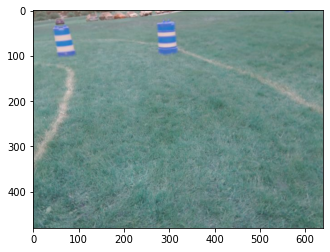

In [45]:
show_image = np.asarray(test_data[30]['image'])
show_image = np.swapaxes(show_image, 2, 0)
show_image = np.swapaxes(show_image, 1, 0)
show_image = show_image.astype(np.uint8)
np.shape(show_image)
plt.imshow(show_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


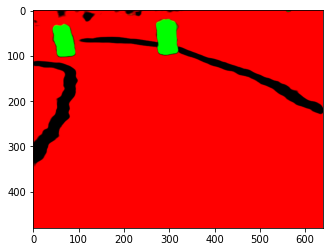

In [49]:
show_image = np.asarray(predictions[30])
show_image = np.swapaxes(show_image, 2, 0)
show_image = np.swapaxes(show_image, 1, 0)
show_image = show_image.astype(np.float64)
np.shape(show_image)
plt.imshow(show_image)

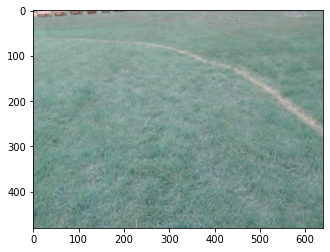

In [42]:
show_image = np.asarray(test_data[19]['image'])
show_image = np.swapaxes(show_image, 2, 0)
show_image = np.swapaxes(show_image, 1, 0)
show_image = show_image.astype(np.uint8)
np.shape(show_image)
plt.imshow(show_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


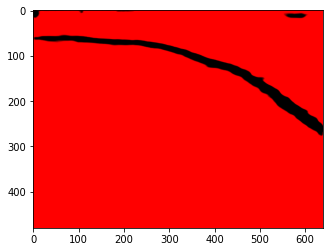

In [43]:
show_image = np.asarray(predictions[19])
show_image = np.swapaxes(show_image, 2, 0)
show_image = np.swapaxes(show_image, 1, 0)
show_image = show_image.astype(np.float64)
np.shape(show_image)
plt.imshow(show_image)

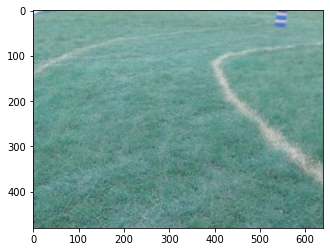

In [84]:
show_image = np.asarray(test_data[141]['image'])
show_image = np.swapaxes(show_image, 2, 0)
show_image = np.swapaxes(show_image, 1, 0)
show_image = show_image.astype(np.uint8)
np.shape(show_image)
plt.imshow(show_image)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


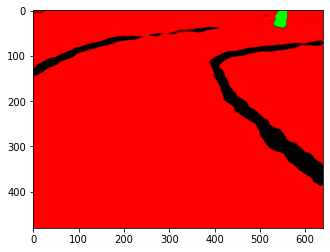

In [83]:
show_image = np.asarray(predictions[141]) #132, 134
show_image = np.swapaxes(show_image, 2, 0)
show_image = np.swapaxes(show_image, 1, 0)
show_image = show_image.astype(np.float64)
np.shape(show_image)
plt.imshow(show_image)

In [0]:
%load_ext tensorboard
%tensorboard --logdir {'content/full_model2'}

In [0]:
LOG_DIR = './content/full_model2'

get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6007 &'
    .format(LOG_DIR)
)
# Install
! npm install -g localtunnel

# Tunnel port 6006 (TensorBoard assumed running)
get_ipython().system_raw('lt --port 6007 >> url.txt 2>&1 &')

# Get url
! cat url.txt


In [0]:
!npm i -g npm